<a href="https://colab.research.google.com/github/Nadian-Ali/ImageClassification/blob/main/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive", force_remount =True)

Mounted at /content/drive


In [ ]:
%pwd


'/content'

In [ ]:
%lsd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [4]:
%cd /content/drive/MyDrive/ImageClassification

/content/drive/MyDrive/ImageClassification


<h1> Improt Packages </h1>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

<h1> Download Dataset </h1>

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('/content/drive/MyDrive/ImageClassification/data', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
!tar -xzvf "/content/drive/MyDrive/ImageClassification/data.tar.gz" # "/content/drive/My Drive/ImageClassification"

<h1>Dataset Root</h1>

In [6]:
data_dir = '/content/drive/MyDrive/ImageClassification/flower_photos'

In [7]:
batch_size = 32
img_height = 256
img_width = 256

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  #color_mode = "grayscale",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 2 classes.
Using 1066 files for training.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'sunflowers']


In [26]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  #color_mode = "grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 2 classes.
Using 266 files for validation.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [12]:
normalization_layer = layers.Rescaling(1./255)

<h1>dataset transform for normalization</h1>

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [13]:
print(len(class_names))
num_classes = len(class_names)

2


<h1>Data augmentation </h1>

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.1),
  ]
)

<h1> visualize augmentation<h1>

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
print(num_classes)

2


<h1>My Model</h1>

In [ ]:
image_size = (180, 180)
def my_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(8, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)  
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
   # x = layers.MaxPooling2D()(x)
   # x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1,activation = 'sigmoid')(x)
    
    return keras.Model(inputs, outputs)


In [ ]:
model_mine = my_model(input_shape=image_size + (1,), num_classes=num_classes)
#keras.utils.plot_model(model_mine, show_shapes=True)  #draw model if you want

In [ ]:
model_mine.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
epochs=10 
history = model_mine .fit(
  train_ds, 
  validation_data=val_ds, 
  epochs=epochs
)

Epoch 1/10
34/34 [==============================] - 29s 704ms/step - loss: 0.7364 - accuracy: 0.5413 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
34/34 [==============================] - 25s 735ms/step - loss: 0.6885 - accuracy: 0.5713 - val_loss: 0.6731 - val_accuracy: 0.6805
Epoch 3/10
34/34 [==============================] - 22s 666ms/step - loss: 0.6671 - accuracy: 0.6304 - val_loss: 0.6398 - val_accuracy: 0.6992
Epoch 4/10
34/34 [==============================] - 21s 613ms/step - loss: 0.6436 - accuracy: 0.6698 - val_loss: 0.6276 - val_accuracy: 0.7406
Epoch 5/10
34/34 [==============================] - 22s 641ms/step - loss: 0.6226 - accuracy: 0.6801 - val_loss: 0.5877 - val_accuracy: 0.7444
Epoch 6/10
34/34 [==============================] - 22s 660ms/step - loss: 0.5979 - accuracy: 0.7251 - val_loss: 0.5853 - val_accuracy: 0.7594
Epoch 7/10
34/34 [==============================] - 22s 644ms/step - loss: 0.5907 - accuracy: 0.7392 - val_loss: 0.5741 - val_accuracy: 0.7707

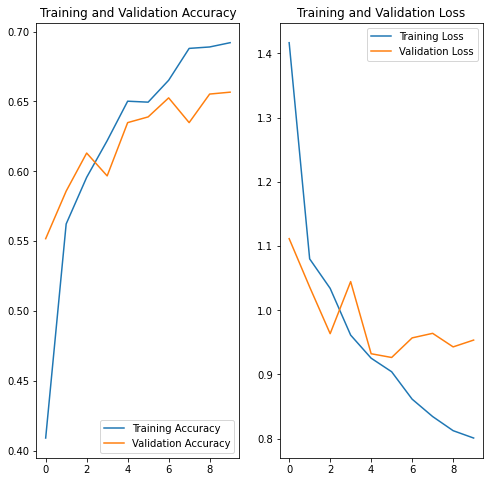

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1>Predict new Data<h1>

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

<h1>My Model fine tune </h1>

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model_ft = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_ft.compile(optimizer='rmsprop', loss='BinaryCrossentropy')


<h1>Train the classifier</h1>

In [24]:
epochs=10 
history = model_ft.fit(
  train_ds, 
  validation_data=val_ds, 
  epochs=epochs
)

Epoch 1/10


ValueError: ignored

In [ ]:

# train the model on the new data for a few epochs
model.fit(...) 

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(...)

<h1>Other models</h1>

<h1> Define model with Function API</h1>

In [ ]:

image_size = (180, 180)
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)




In [ ]:
model_functional = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model_functional, show_shapes=True)  #draw model if you want

In [ ]:
model_functional.compile(
    optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [ ]:
epochs=2
history = model_functional.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
92/92 [==============================] - 779s 8s/step - loss: 0.0000e+00 - accuracy: 0.2010 - val_loss: 0.0000e+00 - val_accuracy: 0.2398
Epoch 2/2
92/92 [==============================] - 769s 8s/step - loss: 0.0000e+00 - accuracy: 0.2299 - val_loss: 0.0000e+00 - val_accuracy: 0.2398


<h1>Sequential Model </h1>

In [ ]:


model = Sequential([
  data_augmentation,                
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_functional.summary()

<h1>Predice new data</h1>

In [ ]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
tst_img = '/content/drive/MyDrive/ImageClassification/flower_photos/daisy/5794839_200acd910c_n.jpg'
img = tf.keras.utils.load_img(
    tst_img, target_size=(180,180)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

FileNotFoundError: ignored